<a href="https://colab.research.google.com/github/allnes/pcam_train/blob/master/pcam_lab_5_train_pretrain_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%pip install keras-metrics

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd  '/content/drive/My Drive/DL_PCAM'

/content/drive/My Drive/DL_PCAM


In [3]:
import gzip
import shutil
import pandas as pd
from matplotlib import pyplot
import numpy as np
import cv2 as cv
from keras.utils import HDF5Matrix, normalize
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, Dropout, Activation, Input, ZeroPadding2D, Add

from keras.layers import Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras_metrics as ksm
import tensorflow as tf

Using TensorFlow backend.


In [0]:
train_x_name = 'camelyonpatch_level_2_split_train_x.h5'
train_y_name = 'camelyonpatch_level_2_split_train_y.h5'

test_x_name = 'camelyonpatch_level_2_split_test_x.h5'
test_y_name = 'camelyonpatch_level_2_split_test_y.h5'

valid_x_name = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y_name = 'camelyonpatch_level_2_split_valid_y.h5'

meta_train_name = 'camelyonpatch_level_2_split_train_meta.csv'
meta_valid_name = 'camelyonpatch_level_2_split_valid_meta.csv'
meta_test_name  = 'camelyonpatch_level_2_split_test_meta.csv'

In [0]:
from keras.utils import HDF5Matrix, normalize

x_train = HDF5Matrix(train_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_train = HDF5Matrix(train_y_name, 'y')

x_valid = HDF5Matrix(valid_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_valid = HDF5Matrix(valid_y_name, 'y')

x_test  = HDF5Matrix(test_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_test  = HDF5Matrix(test_y_name, 'y')

262144
<class 'keras.utils.io_utils.HDF5Matrix'>
<class 'numpy.ndarray'>
(96, 96, 3)


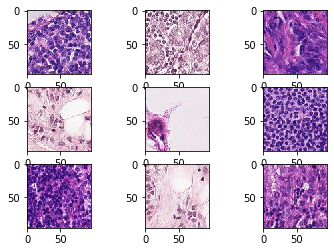

In [6]:
print(len(x_train))
print(type(x_train))
print(type(x_train[0]))
print(x_train[0].shape)

for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()


In [0]:
# Prepare metrics functions
def plot_metrics(code_metrics, name_metrics):
    pyplot.plot(history.history[code_metrics])
    pyplot.plot(history.history['val_' + code_metrics])
    pyplot.title('Model ' + name_metrics)
    pyplot.ylabel(name_metrics)
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Test'], loc='upper left')
    pyplot.show()

def show_metrics(list_metrics, name_stage, name_model):
    name_metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    for i in range(4):
        print(name_model + ' ' + name_stage + ' ' + 
              name_metrics[i] + ' : ' + str(list_metrics[i + 1] * 100))

# Preproc data

In [8]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Reshape
# x_train = np.array(x_train)

y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))

print('input share:', input_shape)
print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

input share: (96, 96, 3)
x_train shape: (262144, 96, 96, 3)
262144 train samples
32768 test samples
y_train shape: (262144, 1)


In [9]:
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))
print("1 in valid : {}".format(np.count_nonzero(y_valid == 1)))
print("0 in valid : {}".format(np.count_nonzero(y_valid == 0)))

1 in train : 131072
0 in train : 131072
1 in valid : 16369
0 in valid : 16399


# Resnet

In [0]:
# Params 
L2_REG = 1e-3       # 1e-4
LEARN_RATE = 1e-3   # 1e-3
BATH_NORM = True    # False

In [0]:
from keras.applications.mobilenet import MobileNet

def mobilenet_train(input_shape, num_classes=1):
    model_res = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    y = Flatten()(model_res.layers[-1].output)
    y = Dense(1, activation='sigmoid', name='fc1', kernel_initializer = 'he_normal')(y)
    model = Model(inputs=model_res.inputs, outputs=y)
    return model

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    # lr = 1e-3
    lr = LEARN_RATE
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

#Compile & run model

In [13]:
model = mobilenet_train(input_shape=input_shape)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics = ['binary_accuracy', 
                         'accuracy',
                          ksm.binary_precision(), 
                          ksm.binary_recall(),
                          ksm.binary_f1_score()
                        ])
# model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '







17227776/17225924 [==============================] - 0s 0us/step

Learning rate:  0.001


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [0]:
import time

BATCH_SIZE = 256
EPOCHS = 10

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [15]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle="batch",
          callbacks=callbacks)


Train on 262144 samples, validate on 32768 samples
Epoch 1/10
Learning rate:  0.001
262144/262144 [==============================] - 305s 1ms/step - loss: 0.2891 - binary_accuracy: 0.9043 - acc: 0.9043 - precision: 0.9104 - recall: 0.8969 - f1_score: 0.9036 - val_loss: 1.2760 - val_binary_accuracy: 0.6747 - val_acc: 0.6747 - val_precision: 0.9834 - val_recall: 0.3552 - val_f1_score: 0.5219
Epoch 2/10
Learning rate:  0.001
262144/262144 [==============================] - 245s 936us/step - loss: 0.1039 - binary_accuracy: 0.9629 - acc: 0.9629 - precision: 0.9665 - recall: 0.9589 - f1_score: 0.9627 - val_loss: 0.5145 - val_binary_accuracy: 0.8282 - val_acc: 0.8282 - val_precision: 0.9486 - val_recall: 0.6940 - val_f1_score: 0.8015
Epoch 3/10
Learning rate:  0.001
262144/262144 [==============================] - 244s 931us/step - loss: 0.0819 - binary_accuracy: 0.9712 - acc: 0.9712 - precision: 0.9739 - recall: 0.9684 - f1_score: 0.9711 - val_loss: 1.3758 - val_binary_accuracy: 0.6651 - va

# Metrics

In [16]:
prediction = model.predict(x_train)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

print(prediction)

>=0.5 (1): 141327
<0.5 (0): 120817
1 in train : 131072
0 in train : 131072
[[1.0243553e-01]
 [9.9999523e-01]
 [7.8935611e-01]
 ...
 [9.9669147e-01]
 [7.4696541e-04]
 [9.9999195e-01]]


In [17]:
prediction = model.predict(x_test)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in test : {}".format(np.count_nonzero(y_test == 1)))
print("0 in test : {}".format(np.count_nonzero(y_test == 0)))

print(prediction)

>=0.5 (1): 13270
<0.5 (0): 19498
1 in test : 16377
0 in test : 16391
[[4.6663314e-02]
 [9.9930197e-01]
 [2.7782077e-01]
 ...
 [9.9999964e-01]
 [9.9749625e-01]
 [6.2957406e-04]]


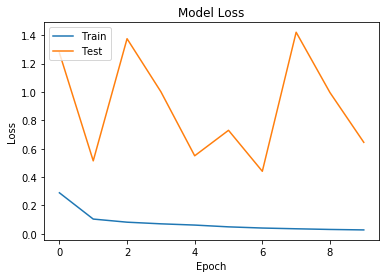

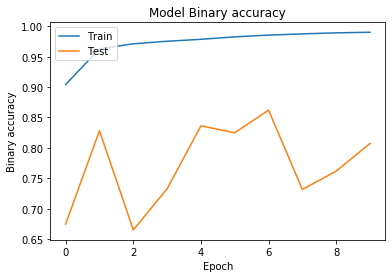

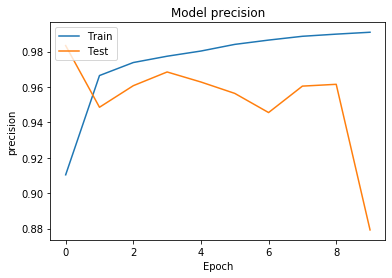

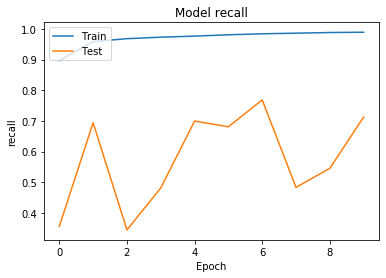

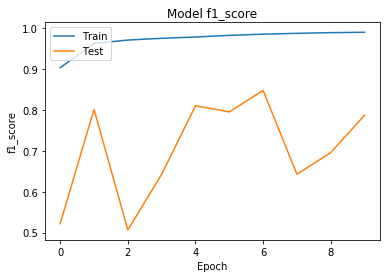

In [18]:
plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Binary accuracy')
plot_metrics('precision', 'precision')
plot_metrics('recall', 'recall')
plot_metrics('f1_score',  'f1_score')

In [20]:
name_model = "mobilenet"
show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)

262144/262144 [==============================] - 105s 400us/step
mobilenet train accuracy : 95.31440734863281
mobilenet train precision : 95.31440734863281
mobilenet train recall : 92.02629363101741
mobilenet train f1-score : 99.22637939445555
32768/32768 [==============================] - 25s 762us/step
mobilenet valid accuracy : 86.60888671875
mobilenet valid precision : 86.60888671875
mobilenet valid recall : 88.87663054001638
mobilenet valid f1-score : 83.66424338637873
32768/32768 [==============================] - 13s 395us/step
mobilenet test accuracy : 80.7403564453125
mobilenet test precision : 80.7403564453125
mobilenet test recall : 87.92765636708418
mobilenet test f1-score : 71.24625999834373
